In [10]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [11]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [12]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

In [13]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))

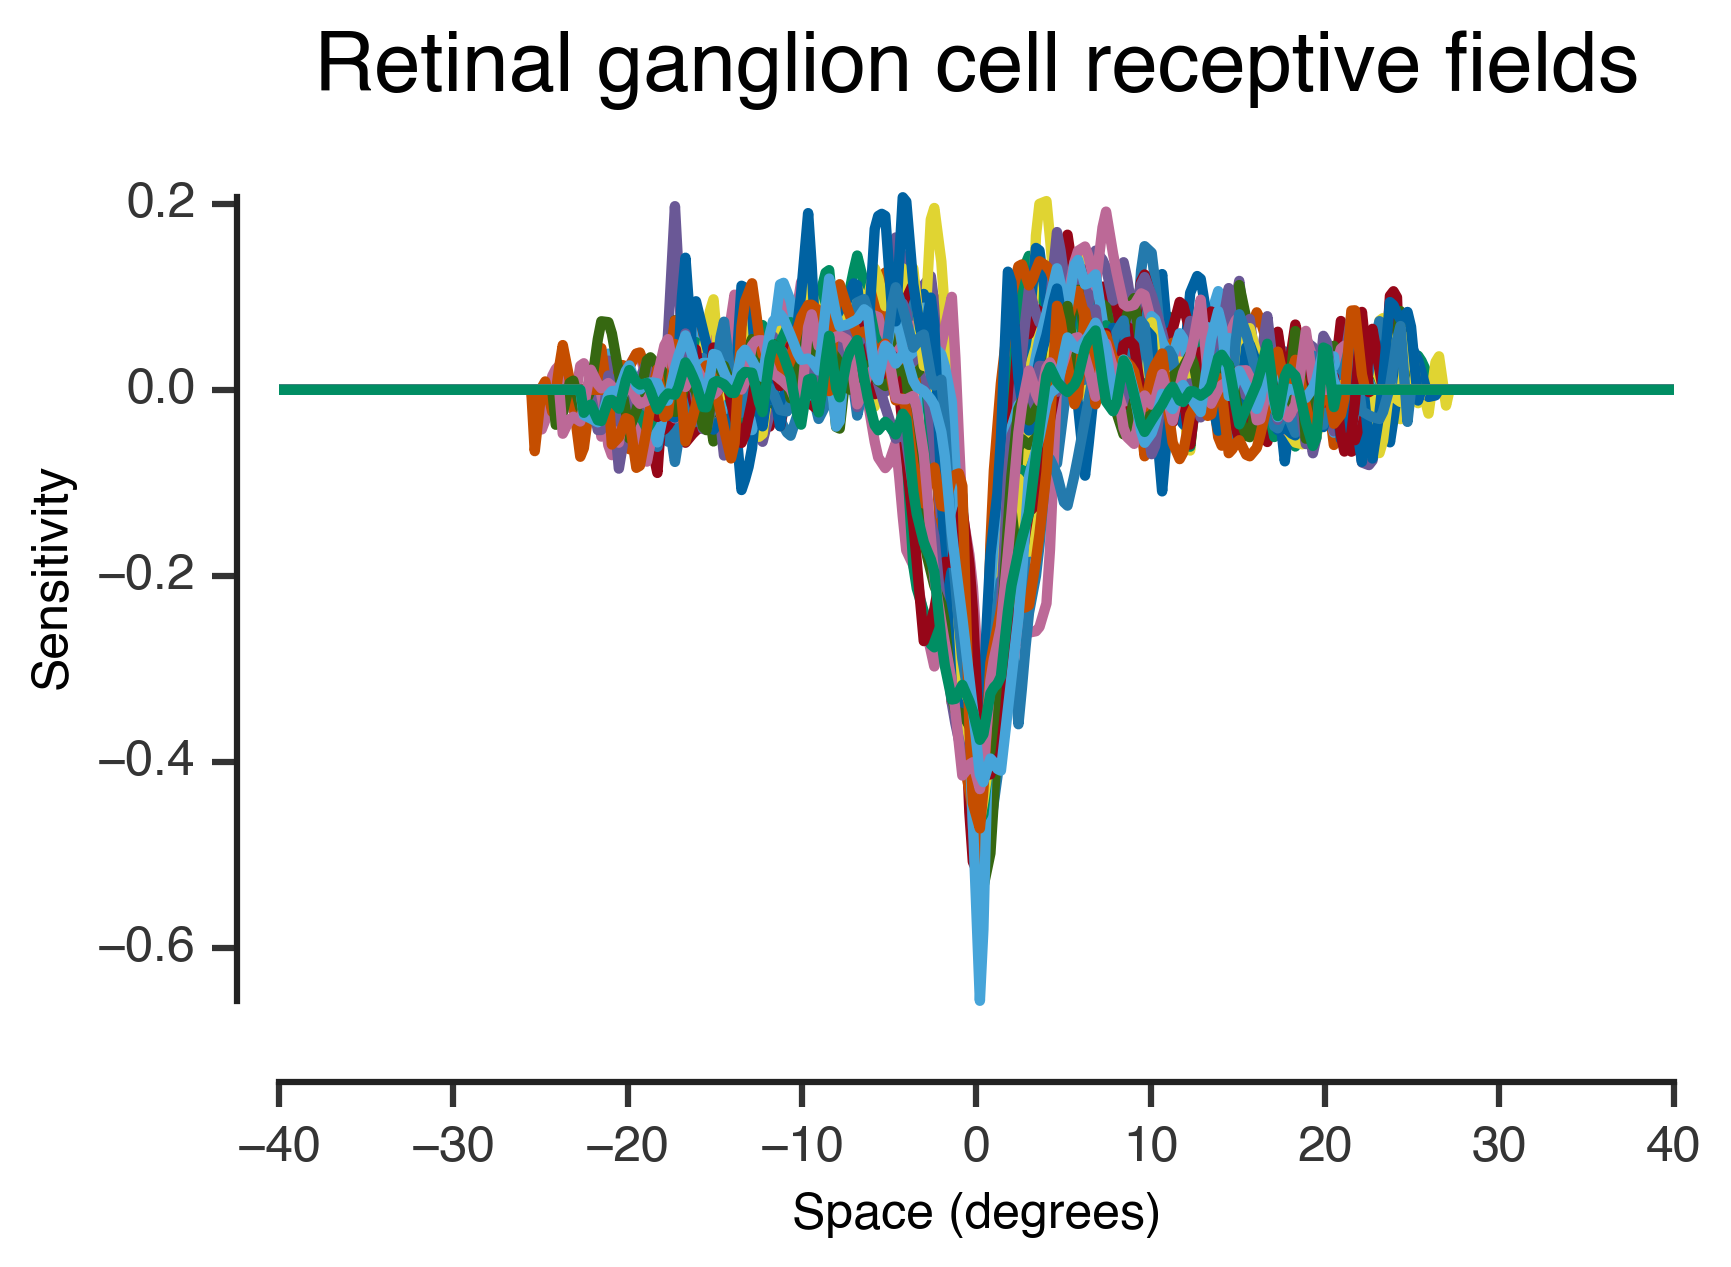

In [14]:
for c in receptive_fields['ganglion']:
    plt.plot(space, c)
plt.xlabel('Space (degrees)')
plt.ylabel('Sensitivity')
plt.title('Retinal ganglion cell receptive fields')
adjust_spines(plt.gca())

Average retinal ganglion cell receptive field

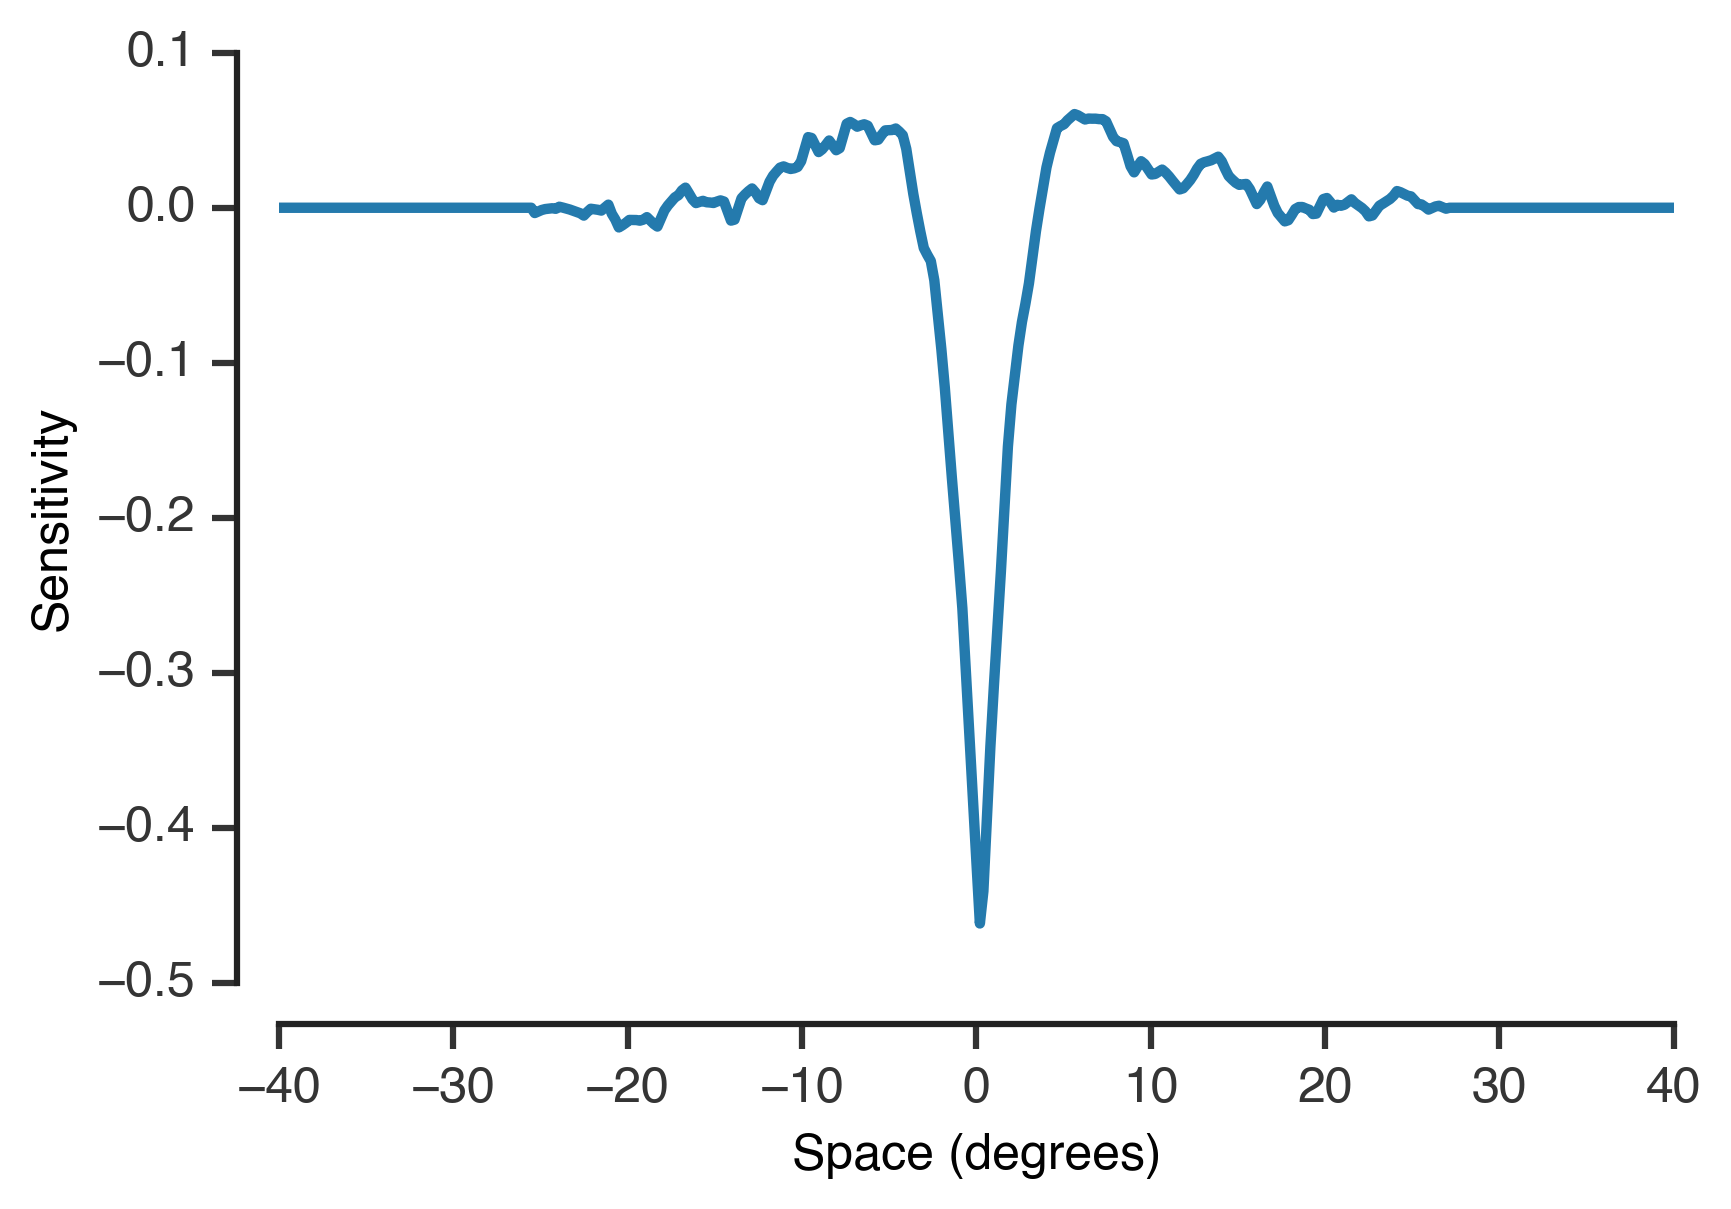

In [15]:
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)
plt.plot(space, average_ganglion_rf)
plt.ylabel('Sensitivity')
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

### Compute projective fields

In [16]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

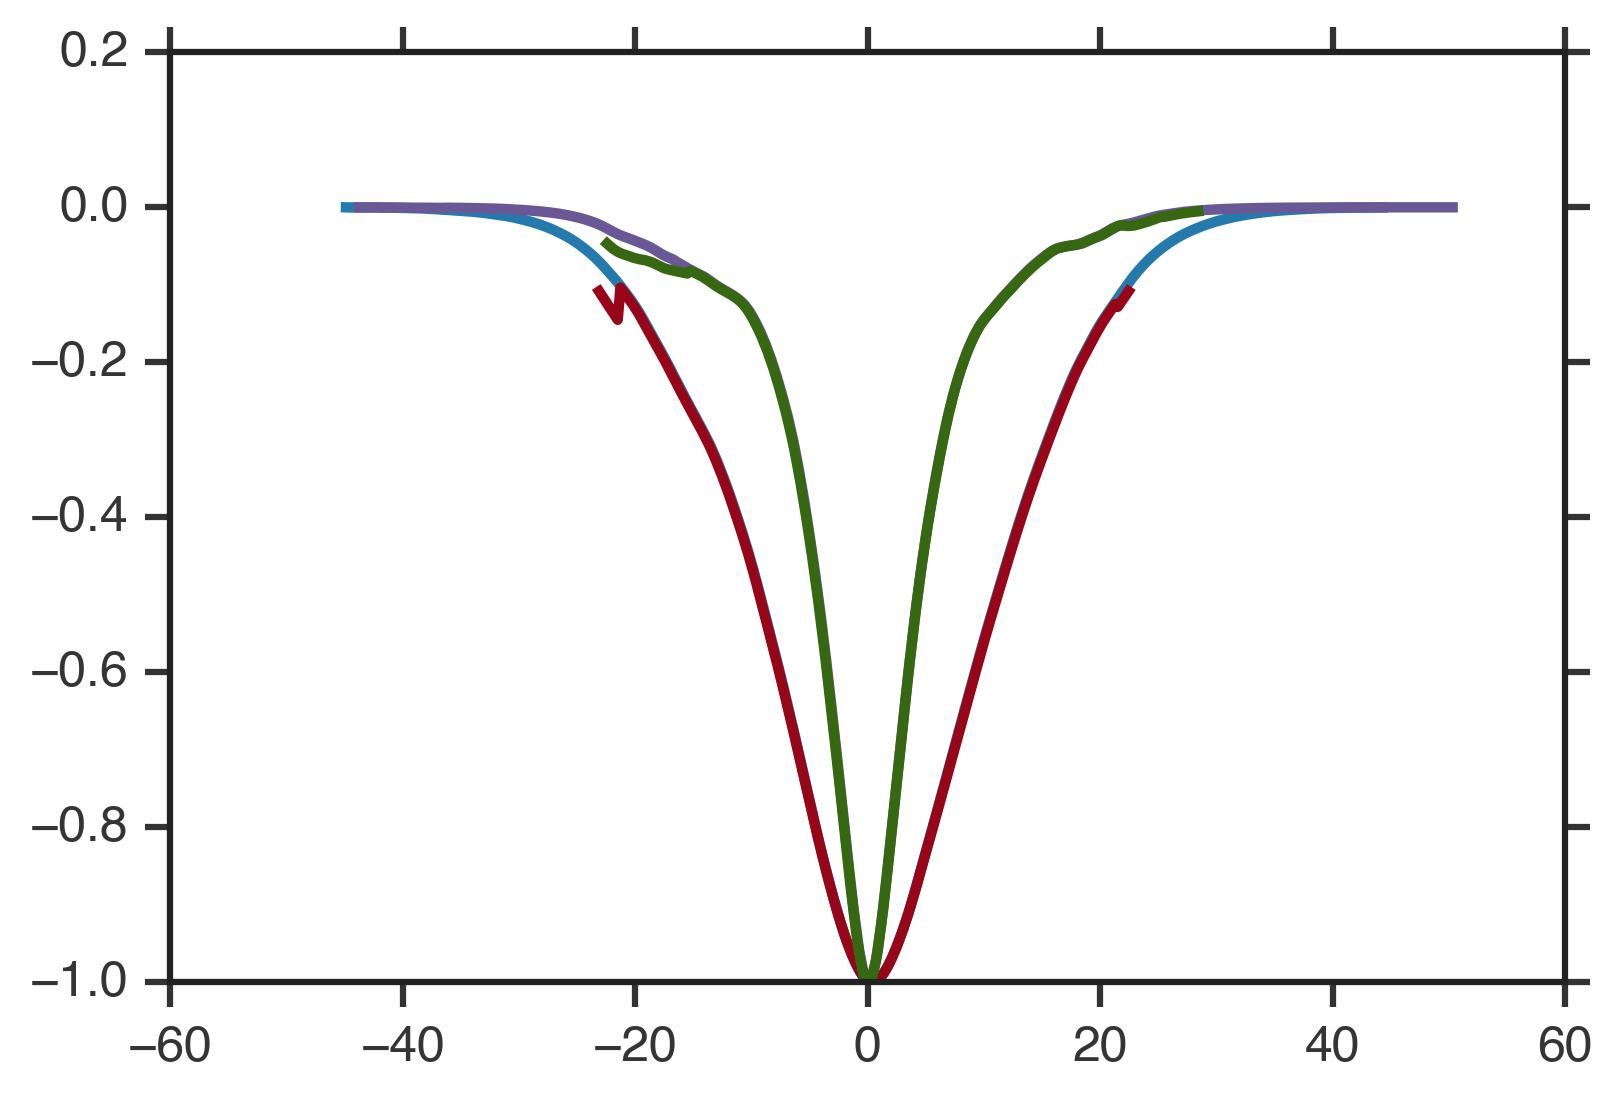

In [17]:
plt.plot(space_h_full, horz_pf_full/np.max(abs(horz_pf_full)))
plt.plot(space_h_same, horz_pf_same/np.max(abs(horz_pf_same)))
plt.plot(space_a_full, ama_pf_full/np.max(abs(ama_pf_full)))
plt.plot(space_a_same, ama_pf_same/np.max(abs(ama_pf_same)))

In [18]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

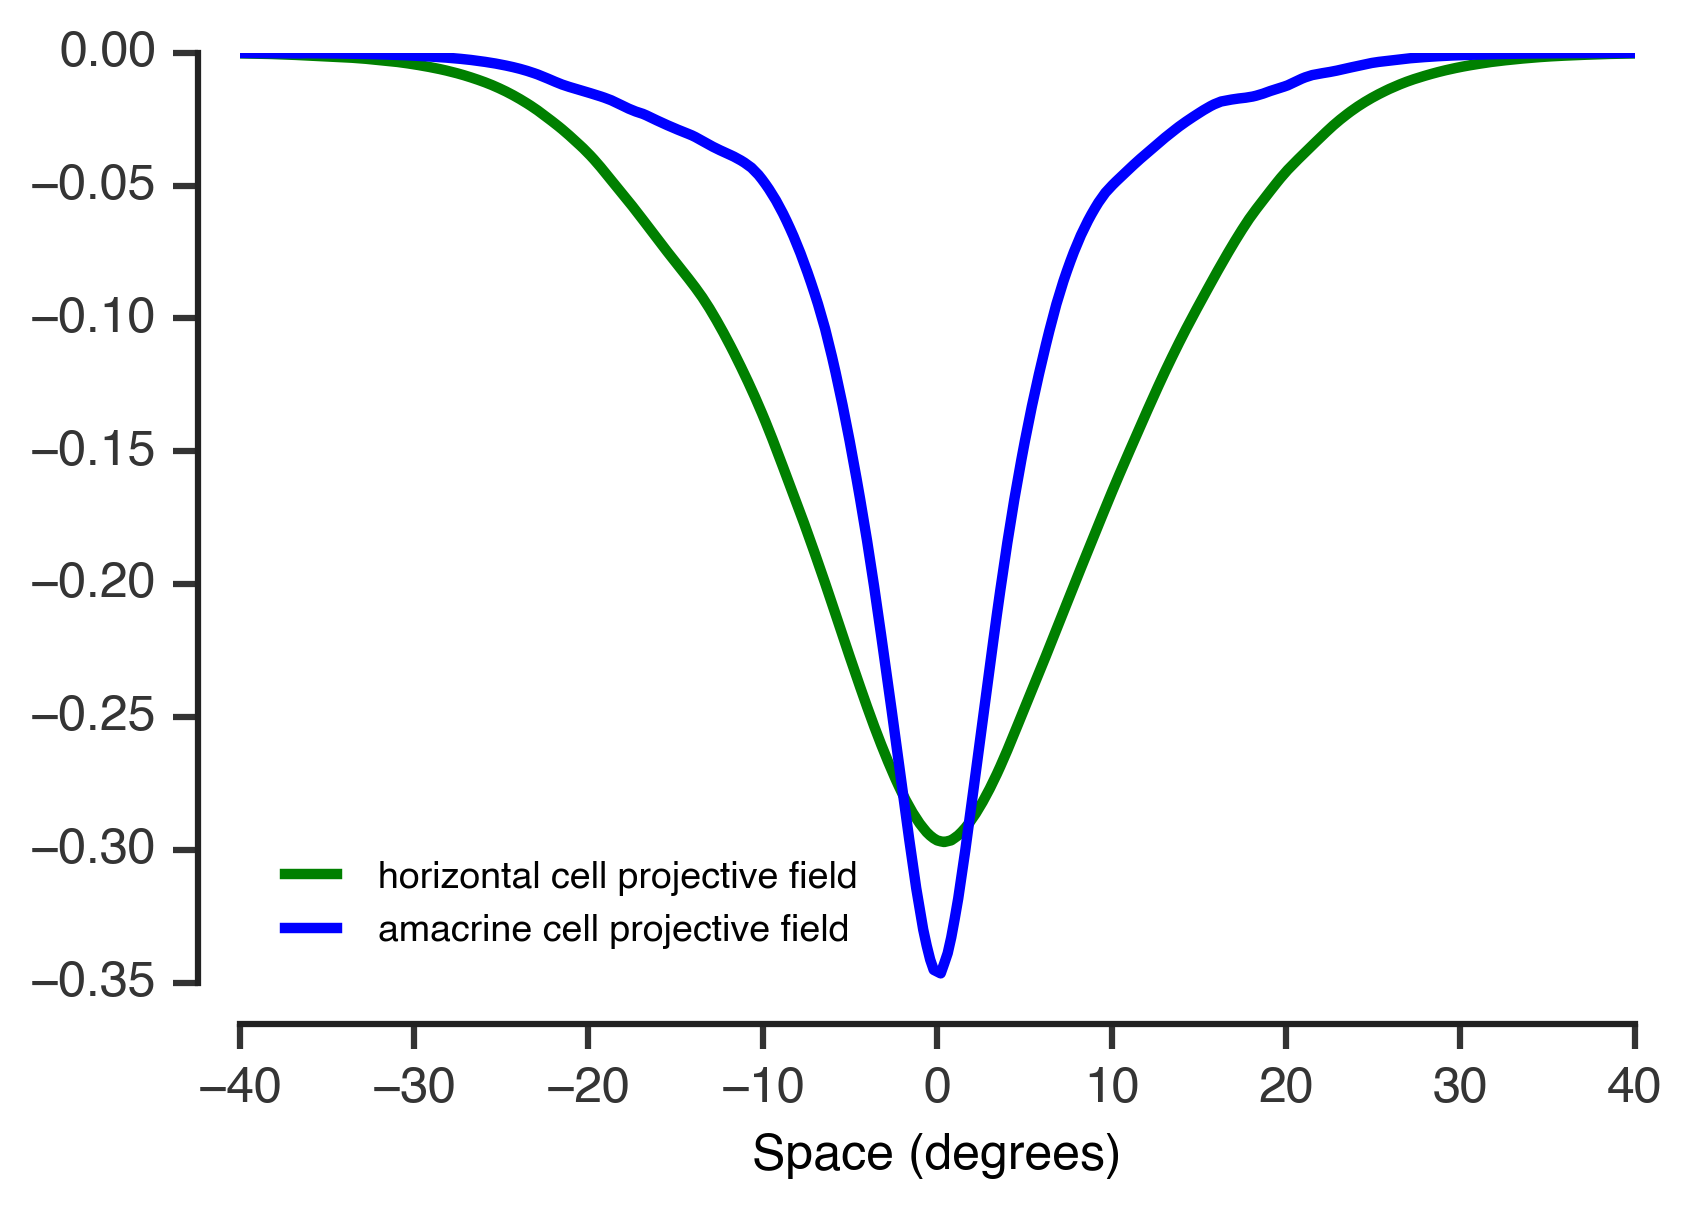

In [19]:
plt.plot(space, horz_pf, 'g', label='horizontal cell projective field')
plt.plot(space, ama_pf, 'b', label='amacrine cell projective field')
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

### Signal

In [21]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [22]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


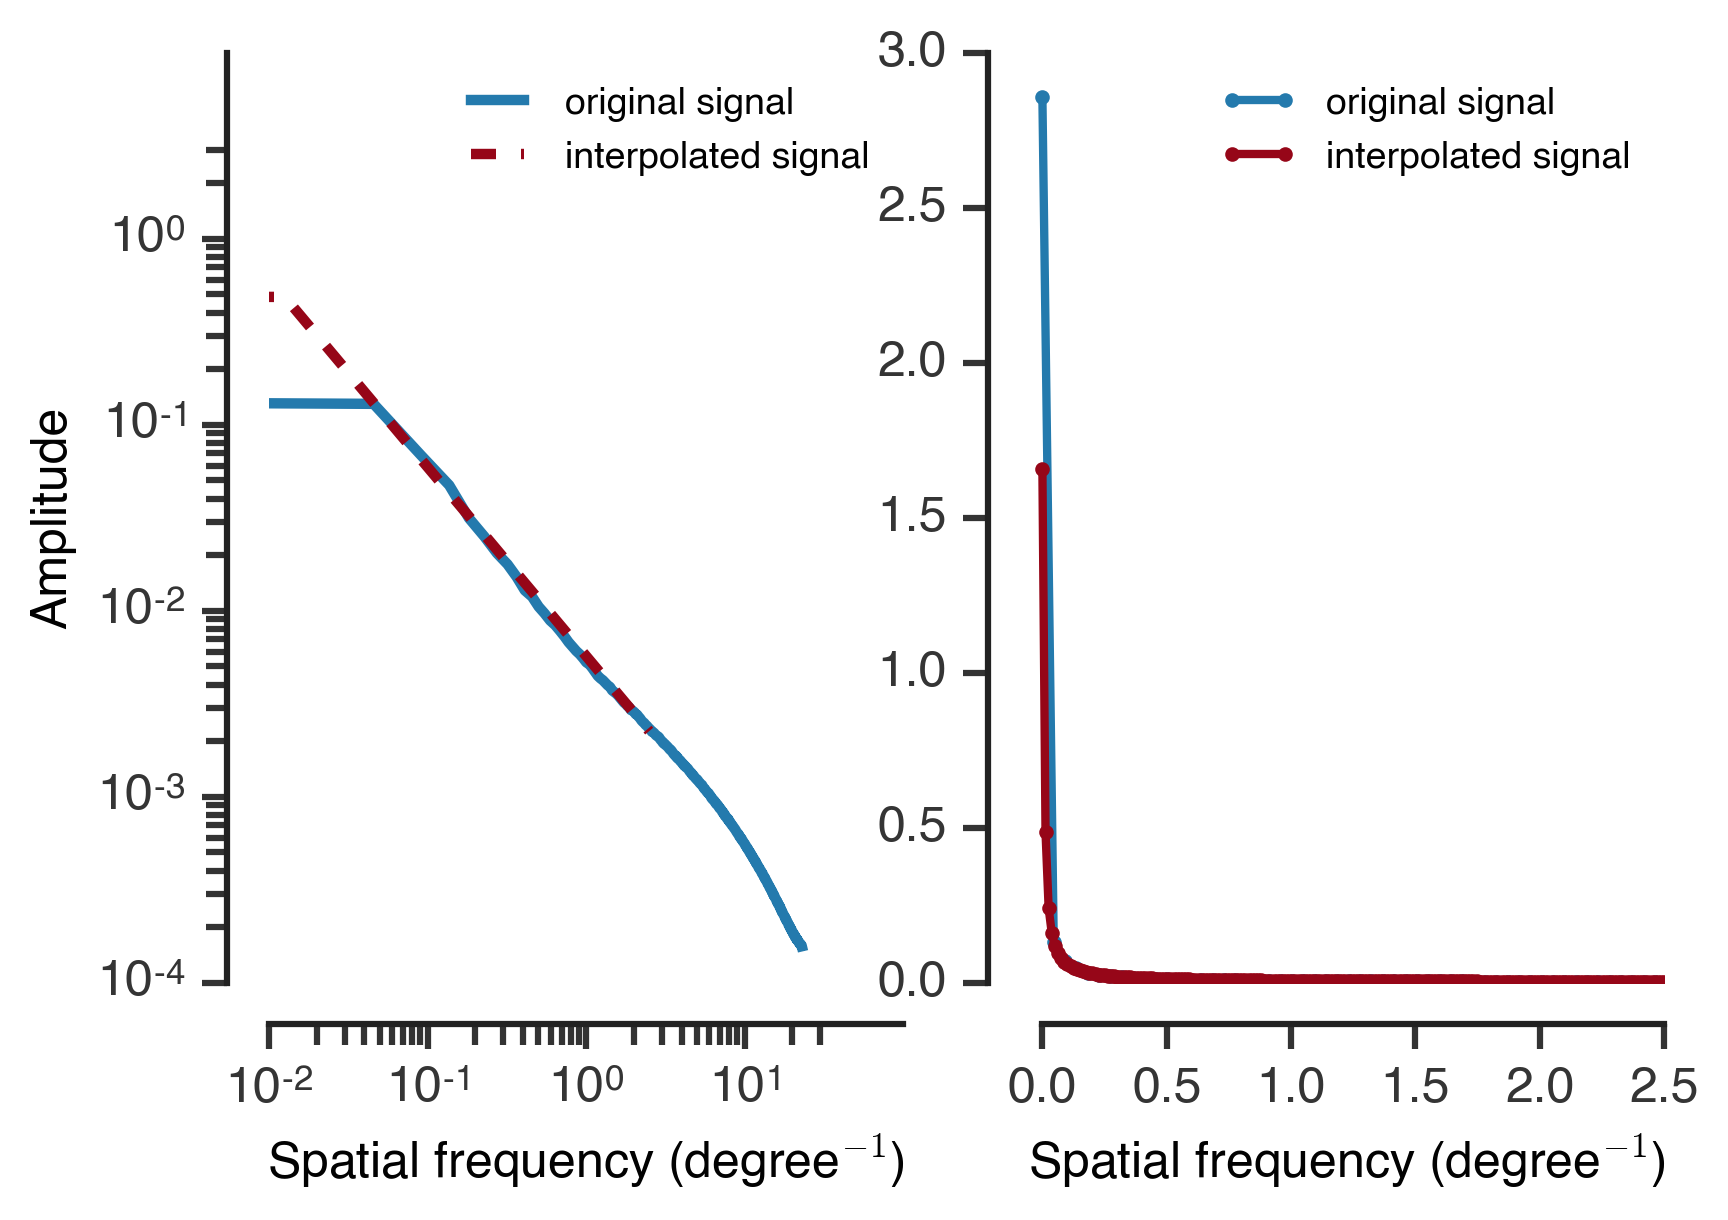

In [23]:
plt.subplot(121)
plt.plot(signal_freqs, signal_amps, label='original signal')
plt.plot(freqs, signal, '--', label='interpolated signal')
plt.legend(frameon=False, fontsize=9)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())
plt.xlabel('Spatial frequency (degree$^{-1}$)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(signal_freqs, signal_amps, '.-', markersize=6, linewidth=2, label='original signal')
plt.plot(freqs, signal, '.-', markersize=6, linewidth=2, label='interpolated signal')
adjust_spines(plt.gca())
plt.xlim(-.05, 2.5)
# plt.ylim(-.05, 1.8)
plt.xlabel('Spatial frequency (degree$^{-1}$)')
# plt.ylabel('Amplitude')
plt.legend(frameon=False, fontsize=9)

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [24]:
input_noise = 0.1
output_noise = 0.35

1.87838253531


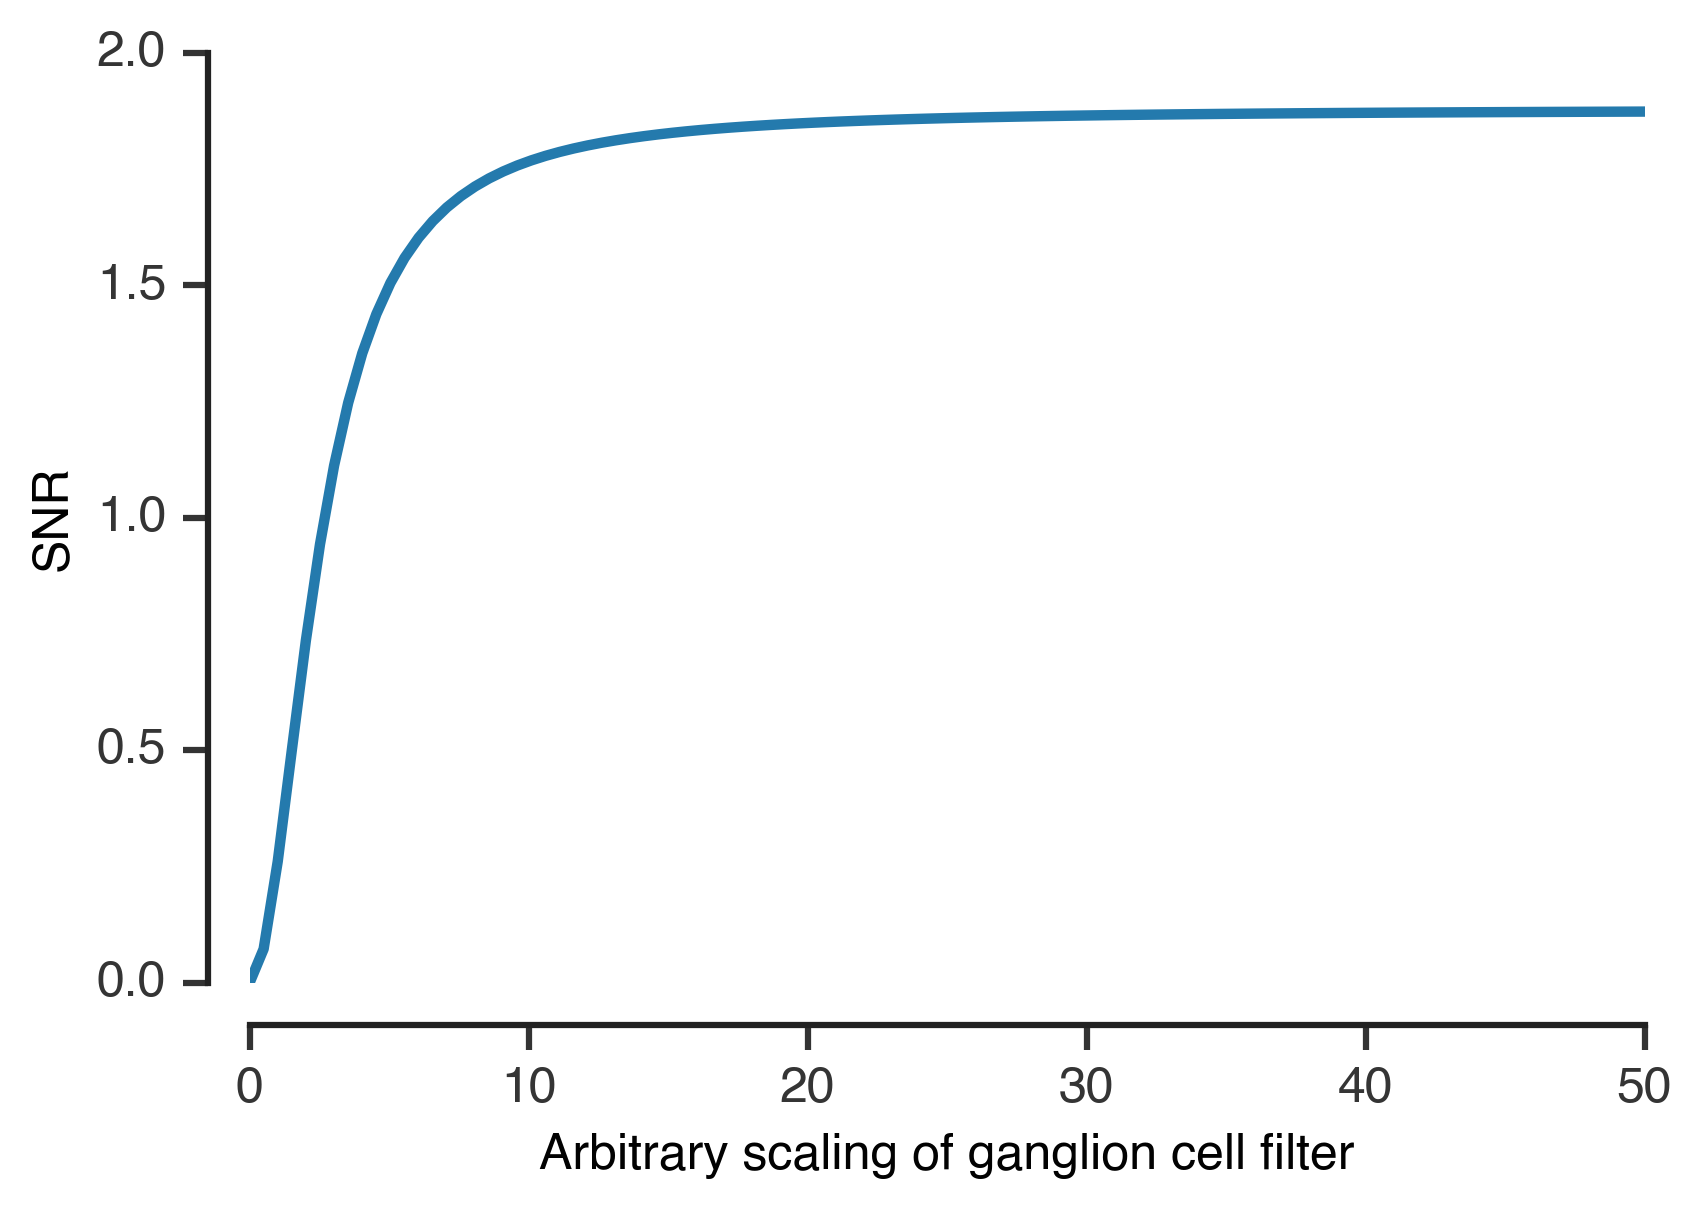

In [25]:
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

### Ideal filter

In [26]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 2.90759635477e-08.


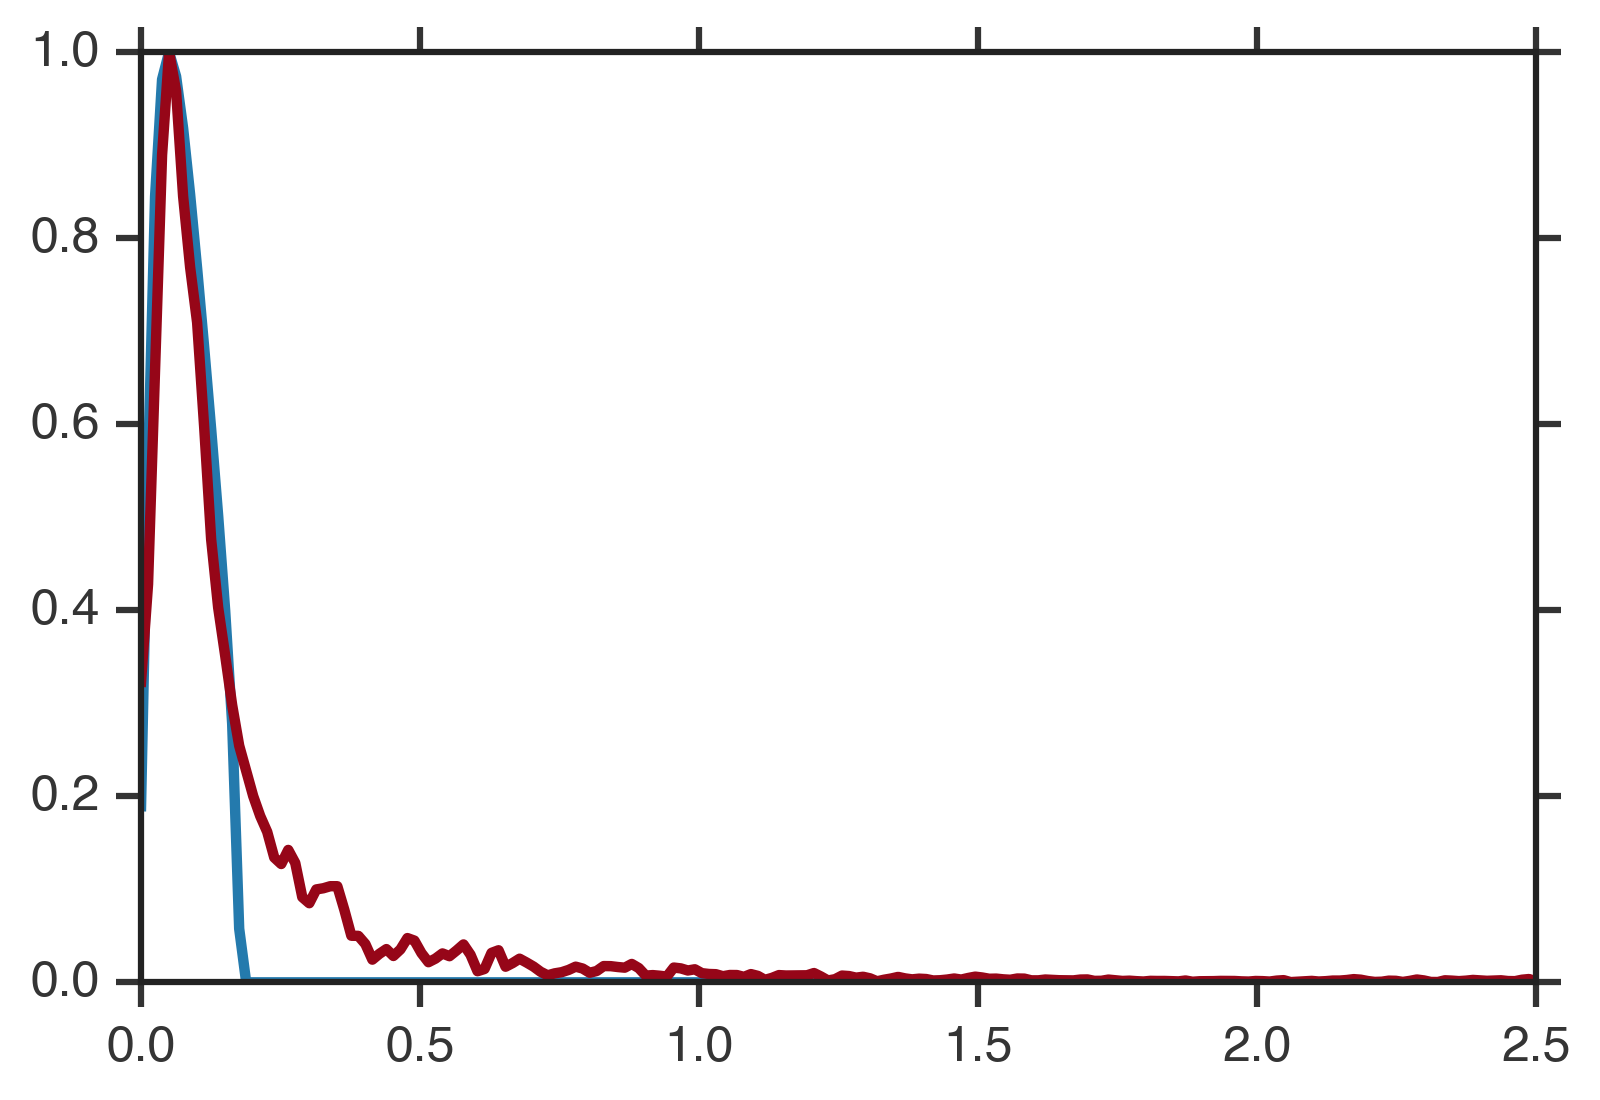

In [27]:
plt.plot(freqs, ideal_filter/np.max(ideal_filter))
plt.plot(freqs, average_ganglion_fft/np.max(average_ganglion_fft))

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [28]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

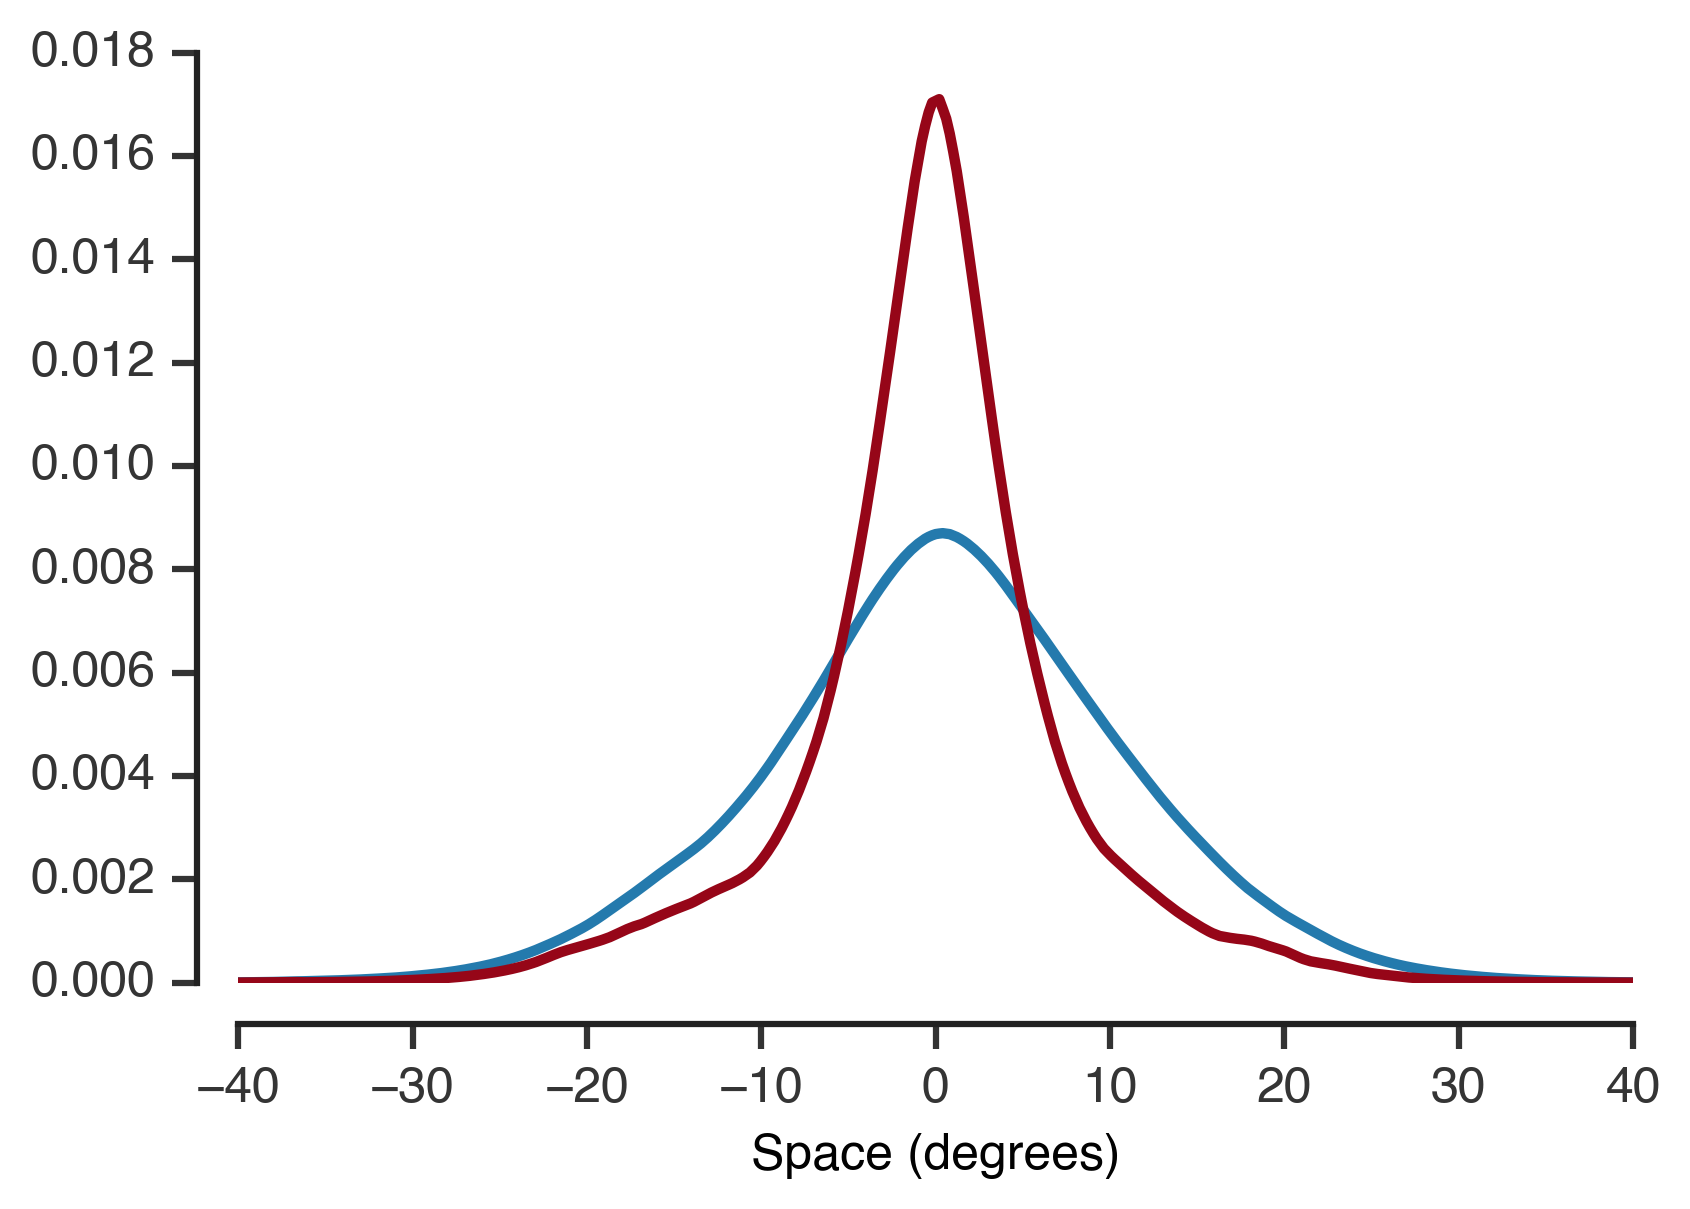

In [29]:
plt.plot(space, horz_pf)
plt.plot(space, ama_pf)
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

Load David's 1721 ganglion cells

In [30]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [32]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg)
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [33]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [38]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(int)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(diff_of_gauss_mu0, space, g)
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype] += 1
#                 print("Couldn't fit cell %d" %idg)

[autoreload of tqdm failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'TqdmTypeError'
]
[autoreload of tqdm._tqdm failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'WeakSet'
]


In [45]:
popt_this

array([  1.91731856,   9.1946828 , -13.48427371,  56.35300487])

In [48]:
celltype

'fast_on'

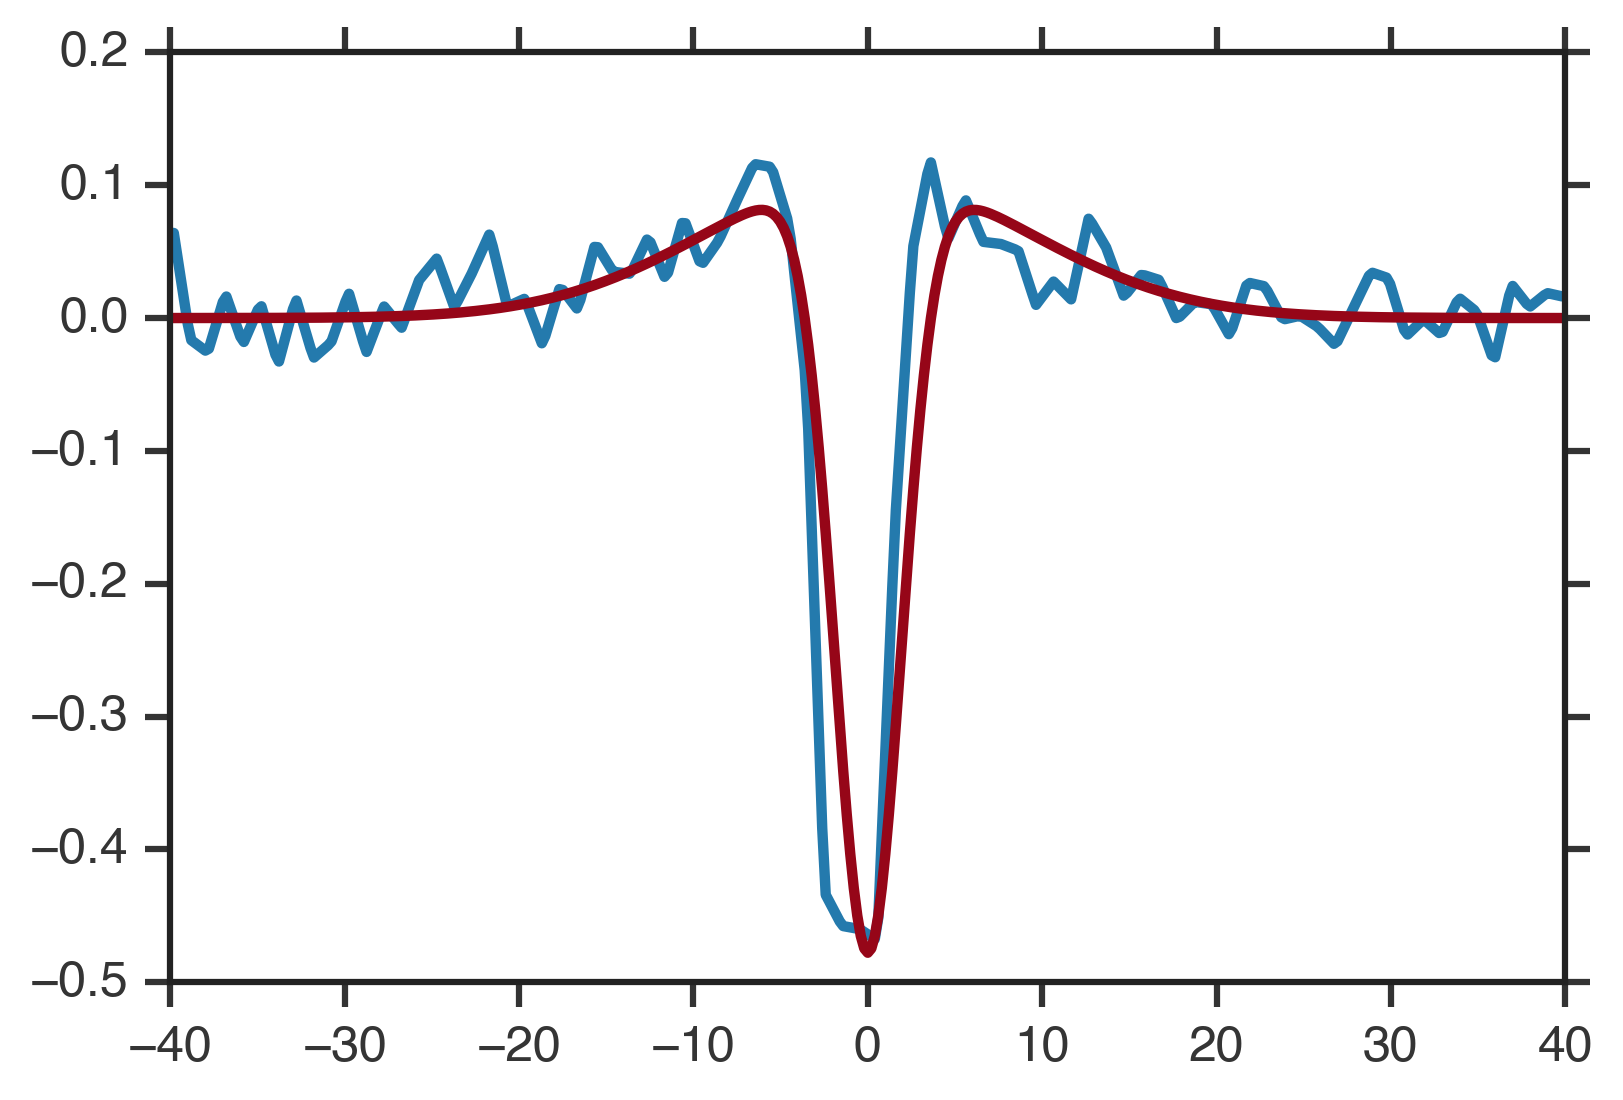

In [44]:
plt.plot(space, g)
plt.plot(space, diff_of_gauss_mu0(space, *popt_this))

Plot the average profile across celltypes

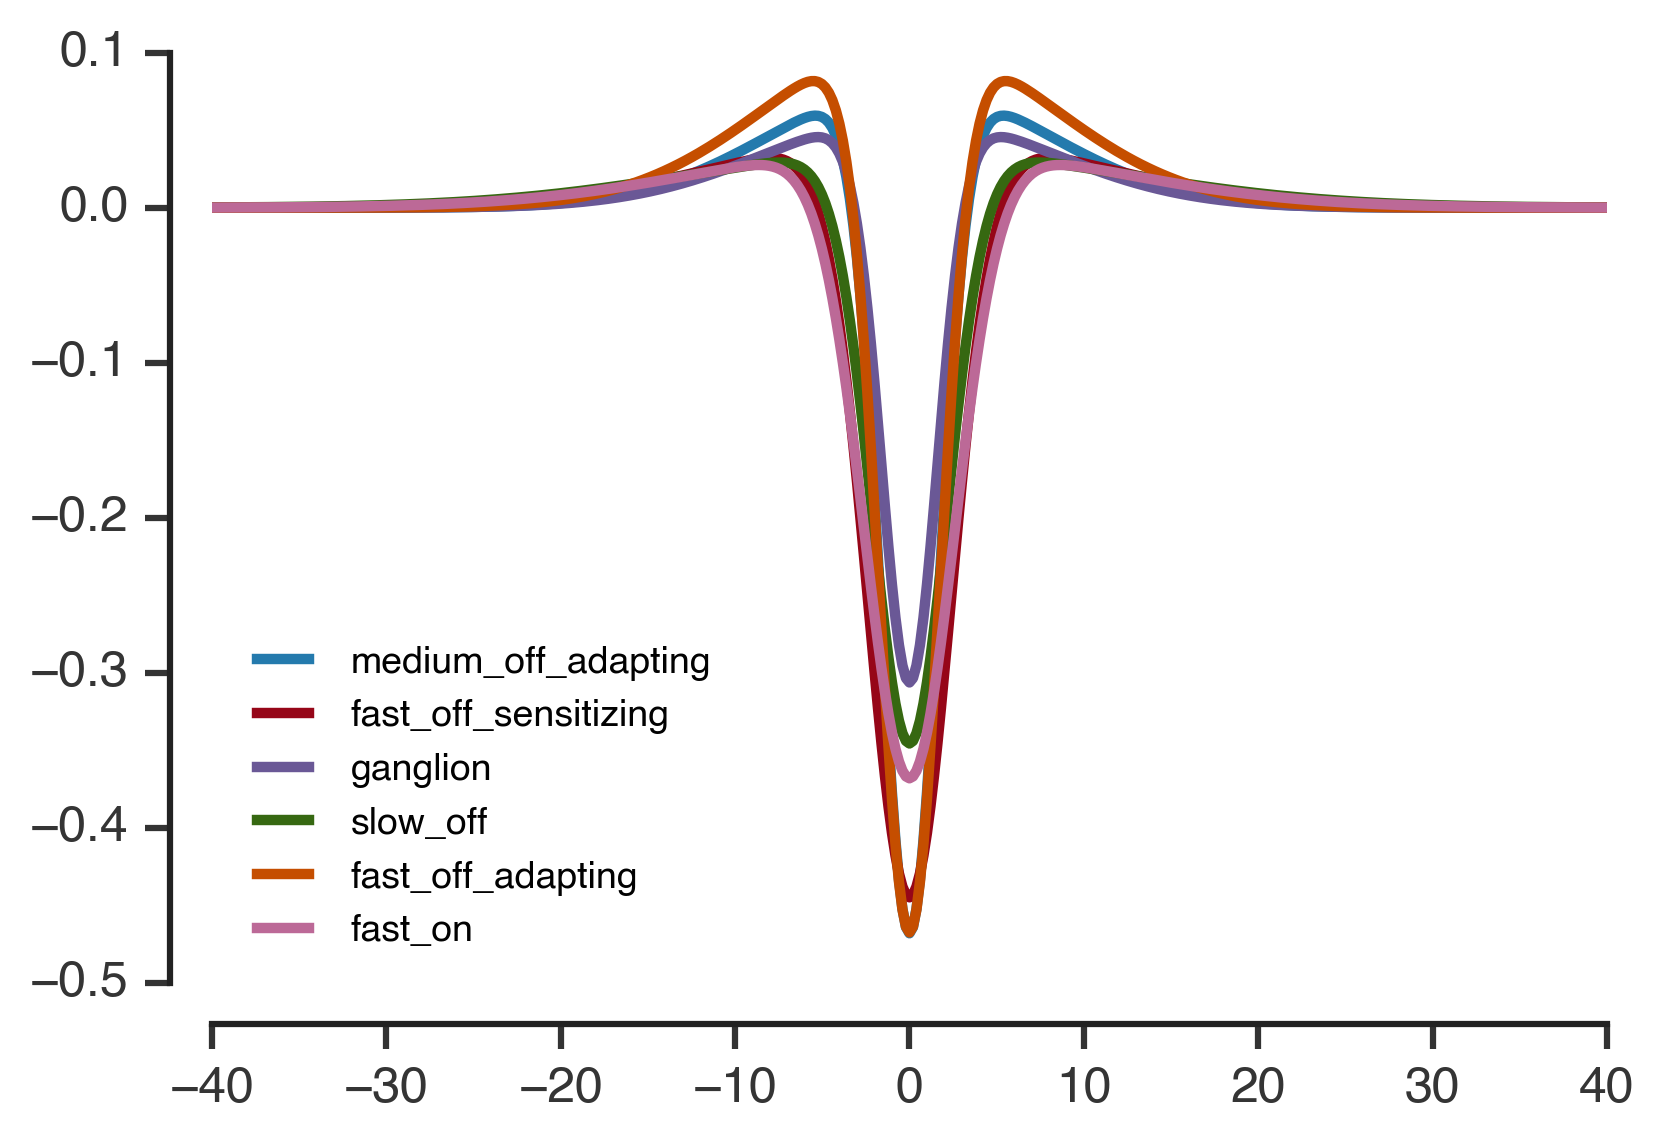

In [70]:
median_center_widths = {}
for celltype in center_widths.keys():
#     cws = np.array(center_widths[celltype])
#     sws = np.array(surround_widths[celltype])
#     css = np.array(center_strengths[celltype])
#     sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(center_widths[celltype])
    median_surround_width = np.median(surround_widths[celltype])
    median_center_strength = np.median(center_strengths[celltype])
    median_surround_strength = np.median(surround_strengths[celltype])
    plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
                                     median_center_strength, median_surround_strength), label=celltype)
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())

In [69]:
median_center_widths

{'fast_off_adapting': 1.7530145108784434,
 'fast_off_sensitizing': 2.3800869723998126,
 'fast_on': 2.5864498829813596,
 'ganglion': 1.6231251356026484,
 'medium_off_adapting': 1.661498011462796,
 'slow_off': 2.147735017347459}

Bar charts to visualize diversity

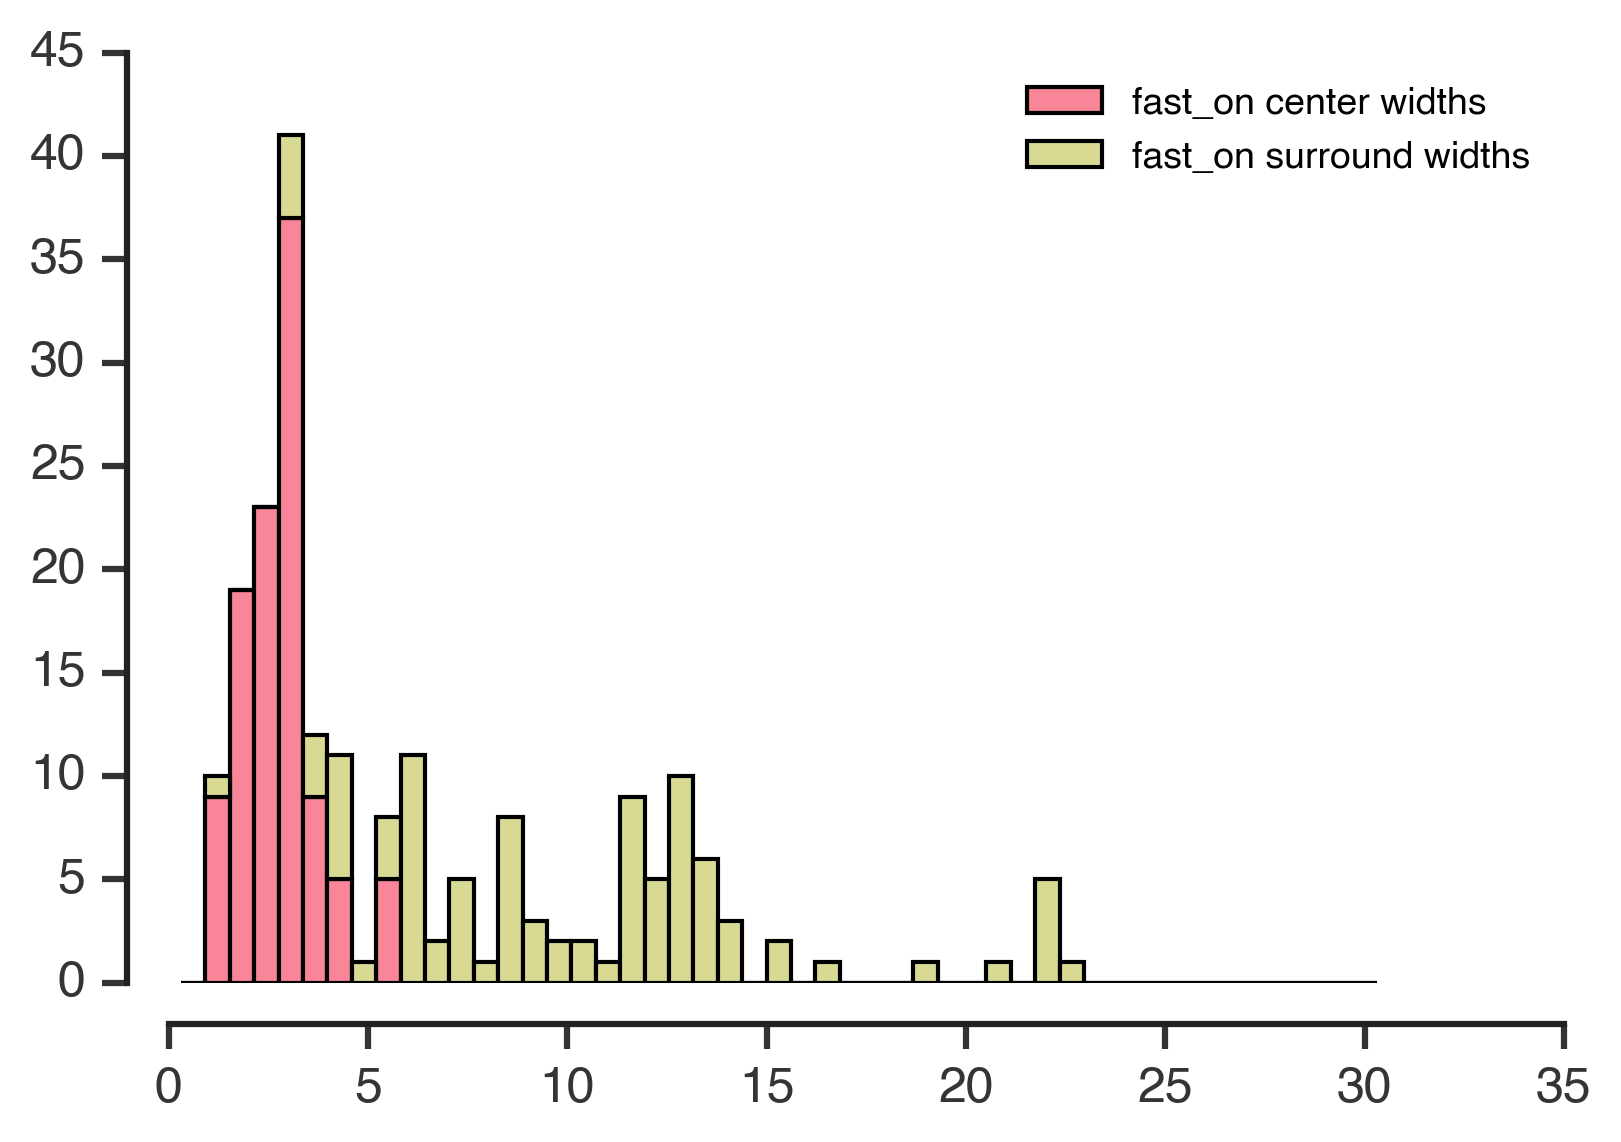

In [86]:
cws = np.array(center_widths[celltype])
sws = np.array(surround_widths[celltype])
# bins = np.linspace(np.min([cws]), np.max(sws[sws < 200]), 50)
bins = np.linspace(0,30,50)
counts, bins = np.histogram(cws[cws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center widths' %celltype)

counts_surr, bins_surr = np.histogram(sws[sws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround widths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

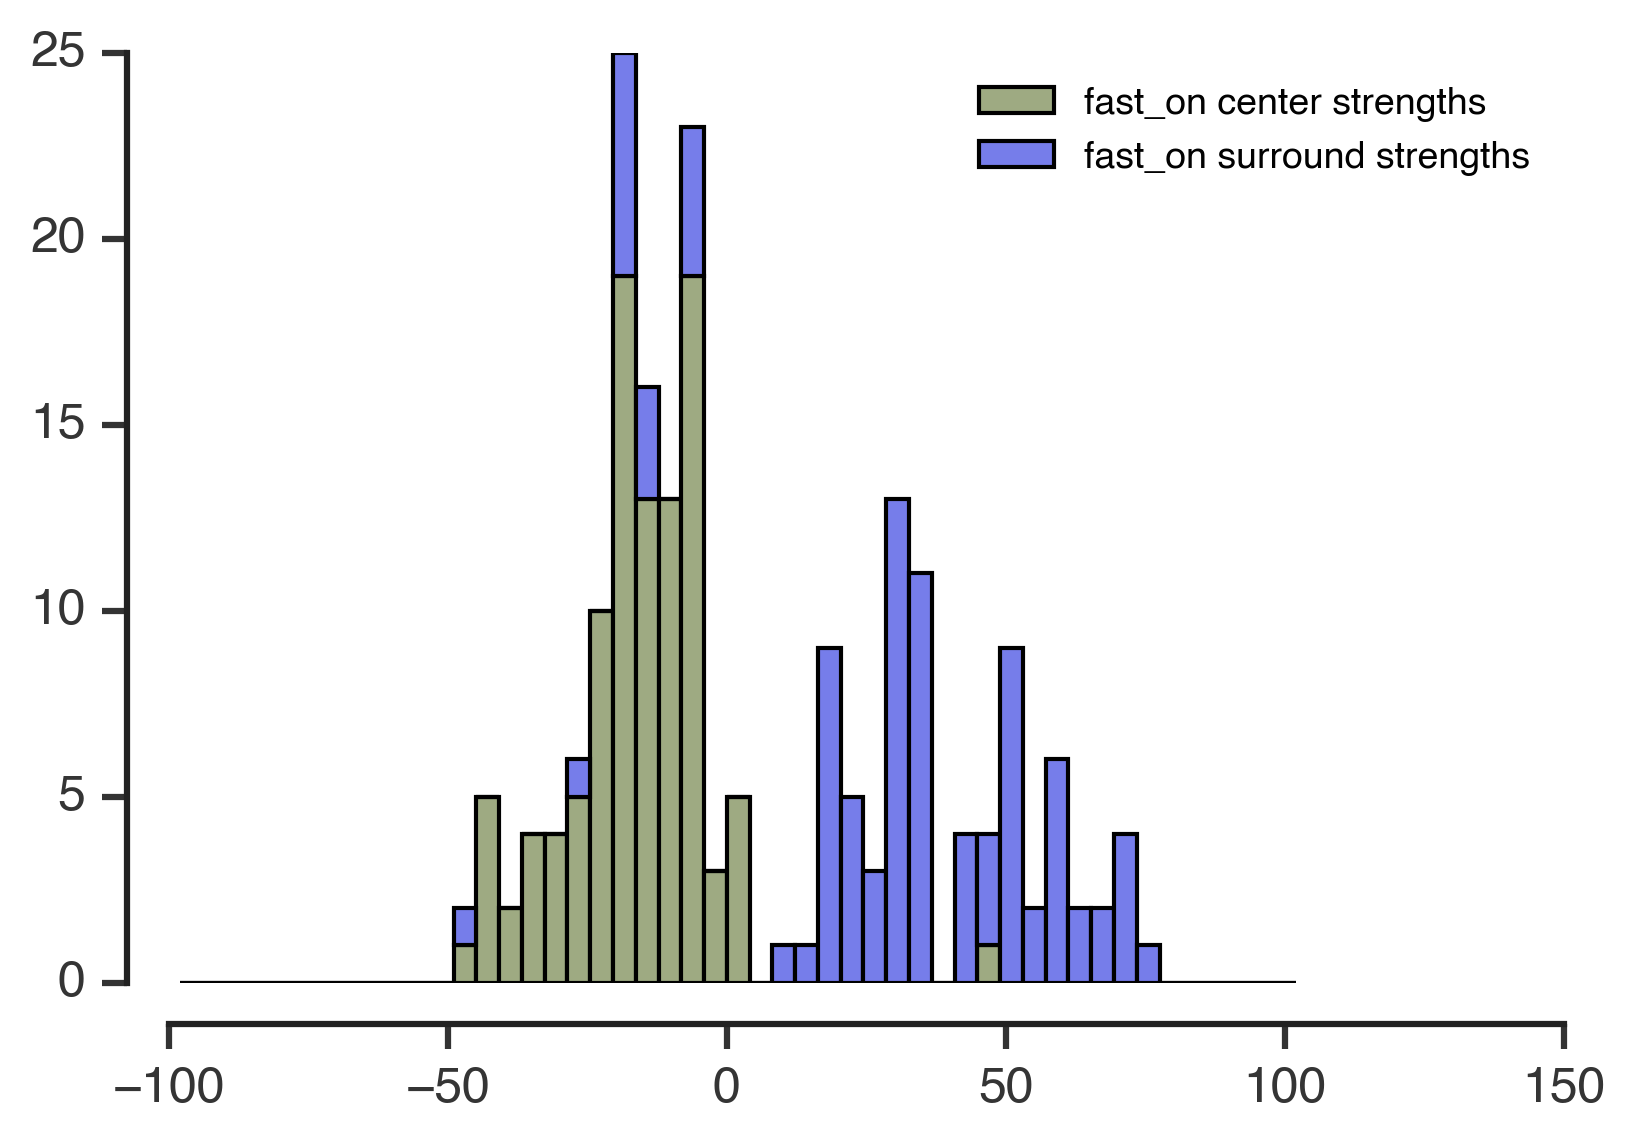

In [83]:
css = np.array(center_strengths[celltype])
sss = np.array(surround_strengths[celltype])
# bins = np.linspace(np.min([css]), np.max(sss), 50)
bins = np.linspace(-100,100,50)
counts, bins = np.histogram(css, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center strengths' %celltype)

counts_surr, bins_surr = np.histogram(sss, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround strengths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

Run info maps

In [40]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [ ]:
target_power = 10e5
init_filt_const = 0.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=mean_center_widths[celltype], mu=0.)
        center /= np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
        print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    signal_power = 2 * np.sum((signal*filt_const*rf_filt)**2) / size
                    noise_power = 2 * np.sum((input_noise*filt_const*rf_filt)**2 + output_noise**2) / size
                    output_power = signal_power + noise_power
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                filt_const = abs(filt_const_opt['x'])

                # compute total information for this particular model
                signal_vars = get_signal_var(signal, filt_const*rf_filt, total_var=False)
                noise_vars = get_noise_var(input_noise, output_noise, filt_const*rf_filt, total_var=False)
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_vars/noise_vars))

100it [00:26,  3.78it/s]

In [ ]:
plt.imshow(info_maps['ganglion'])